Beginning the data collecting by loading in MNIST original, a dataset with 70,000 small images of digits. The images are 28x28 pixels, and are grayscale. The images are already split into a training set (60,000 images) and a test set (10,000 images). The labels are the digits these images represent: integers from 0 to 9.

In [2]:
from scipy.io import loadmat
mnist = loadmat("mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]


Once the data has been loaded in, preprocessing can begin

In [3]:
from sklearn.preprocessing import StandardScaler
import numpy as np
#preprocessing the data.  We must first reshape the data to a 4D array(samples,width,height,number of colors), where each image is a different 2D matrix
#Normalizing the values of the data, could experiment with minmax scaler too.  To do this, we must flatten the data to a 2D array, then turn it back into a 4D array
#I do not need to look for null values because this data does not have any
mnist_data = mnist_data.reshape(-1, 28, 28, 1)
mnist_data_2d = mnist_data.reshape(-1, 28*28)
scaler = StandardScaler()
mnist_data_normalized = scaler.fit_transform(mnist_data_2d)
#After the 2D data has been normalized, return it to a 4D array
mnist_data_normalized = mnist_data_normalized.reshape(-1, 28, 28, 1)

The data must be split into a testing and a training set. The training set will be used to train the model, and the testing set will be used to test the model. The testing set will be 20% of the data, and the training set will be 80% of the data.

In [4]:
from sklearn.model_selection import train_test_split
#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mnist_data_normalized, mnist_label, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
#print(X_train[0])

(56000, 28, 28, 1) (56000,)
(14000, 28, 28, 1) (14000,)


We have 2D representations of the matrixes, they are 28 by 28 pixels. We can visualize the data by reshaping the data into a 28 by 28 matrix, and then plotting it using matplotlib. The data of these images are normalized.

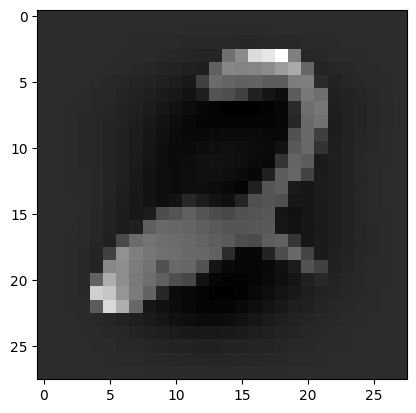

In [5]:
import matplotlib.pyplot as plt
random_nr = np.random.randint(0, 56000) #Selects random image from traning set. There are 56,000 images in traning set.

#Printing out the 2D array of the image
plt.imshow(X_train[random_nr].reshape(28,28), cmap="gray")

plt.show()

Now that we are certain the dataset is valid and ready to be used, we can now begin image augmentation. Image augmentation artificially increases the size of a dataset by modifying images by rotating and zooming them. This is done to prevent overfitting, and to make the model more robust. The images are rotated by 10 degrees, and zoomed by 10%. The images are then reshaped back into a 28 by 28 matrix.

(56000, 28, 28, 1) (56000,)
(64, 28, 28, 1) (64,)
(9984, 28, 28, 1)


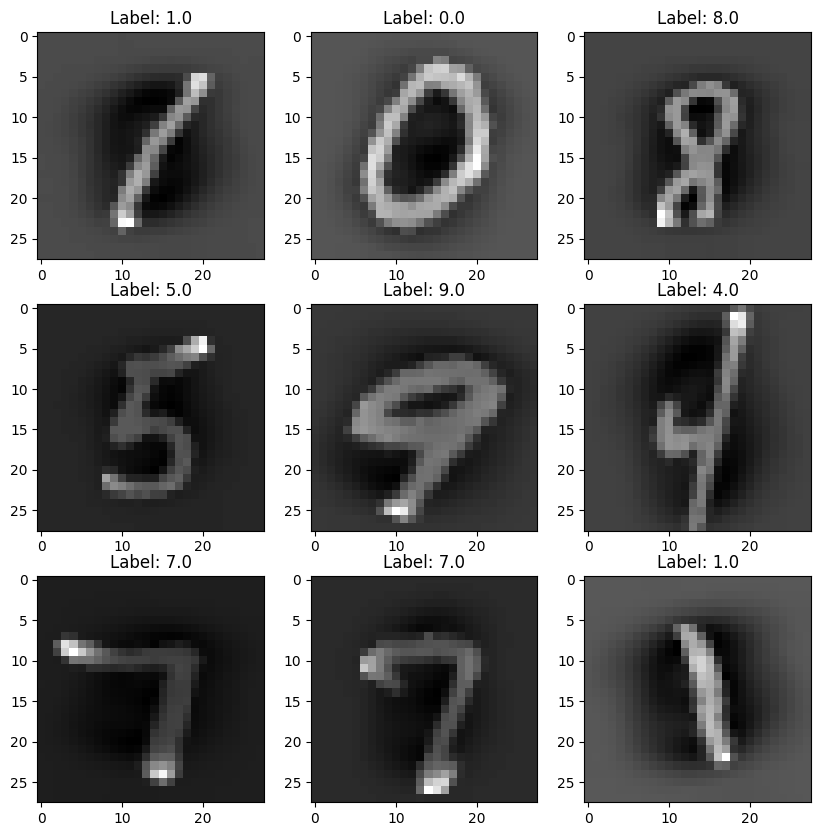

In [12]:
#Attempting to use Keras's image augmentation
import keras.preprocessing.image
from keras.preprocessing.image import ImageDataGenerator
print(X_train.shape, y_train.shape)
datagen = ImageDataGenerator(
        rotation_range=25,  
        zoom_range = 0.20,  
        )
datagen.fit(X_train)

gen_augmented = datagen.flow(X_train, y_train, batch_size=64)
augmented_images = []
augmented_labels = []
for i in range(10000 // 64):
    batch_augmented_images, batch_augmented_labels = next(gen_augmented)
    augmented_images.append(batch_augmented_images)
    augmented_labels.append(batch_augmented_labels)

augmented_images = np.concatenate(augmented_images, axis=0)
augmented_labels = np.concatenate(augmented_labels, axis=0)


print(batch_augmented_images.shape, batch_augmented_labels.shape)
print(augmented_images.shape)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(augmented_images[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {augmented_labels[i]}")
plt.show()

We can now apply CNN model to train and evaluate our dataset. We use multiple layers shown below, and use accuracy and MAE to evaluate the model. Overall, CNN performs well.

In [14]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# One-hot encode the labels
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy","mae", ])

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=5, batch_size=64, validation_data=(X_test, y_test_onehot))


Epoch 1/5
1031/1031 [==============================] - 46s 43ms/step - loss: 0.1643 - accuracy: 0.9487 - mae: 0.0160 - val_loss: 0.0630 - val_accuracy: 0.9805 - val_mae: 0.0066
Epoch 2/5
1031/1031 [==============================] - 37s 36ms/step - loss: 0.0523 - accuracy: 0.9831 - mae: 0.0052 - val_loss: 0.0505 - val_accuracy: 0.9849 - val_mae: 0.0042
Epoch 3/5
1031/1031 [==============================] - 39s 38ms/step - loss: 0.0371 - accuracy: 0.9880 - mae: 0.0036 - val_loss: 0.0355 - val_accuracy: 0.9892 - val_mae: 0.0030
Epoch 4/5
1031/1031 [==============================] - 42s 41ms/step - loss: 0.0280 - accuracy: 0.9913 - mae: 0.0028 - val_loss: 0.0416 - val_accuracy: 0.9876 - val_mae: 0.0032
Epoch 5/5
1031/1031 [==============================] - 42s 41ms/step - loss: 0.0229 - accuracy: 0.9926 - mae: 0.0023 - val_loss: 0.0348 - val_accuracy: 0.9899 - val_mae: 0.0027


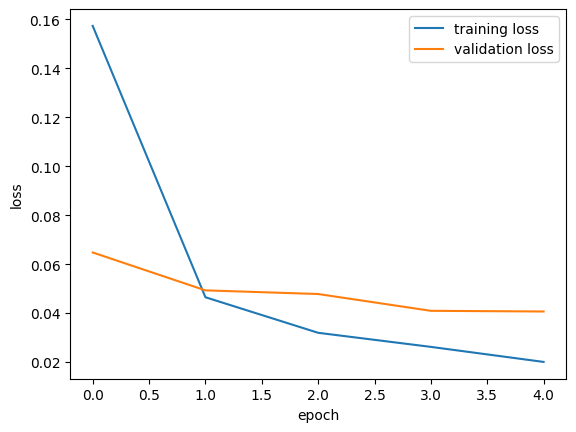

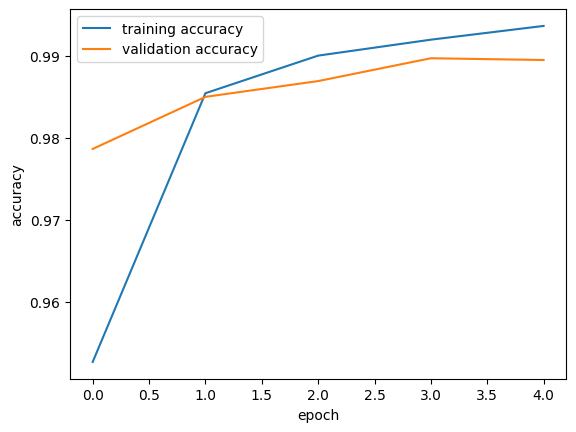

In [10]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


The code below tests out different numbers of augmented images.  four different models are trained, using 1000, 5000, 10000, and 20000 extra images from image augmentation.  The x_train dataset size was increased by 2%, 9%, 18%, and 36% respectively.  The accuracy of the models were all above 99%, but surprisingly the image augmentation had a slight negative effect on the accuracy and MAE of the model.  The MAE was always below .01, and was slowly raised as the number of augmented images increased.  The cause of this is most likely that the model was overfitting with the augmented images, and it negatively affected the accuracy.

In [18]:
additionalImages=[1000, 5000, 10000, 20000]

for iteration in additionalImages:
    datagen = ImageDataGenerator(
        rotation_range=20,  
        zoom_range = 0.15,
        width_shift_range=0.2,
        brightness_range=[0.5,1.0],
          
        )
    datagen.fit(X_train)

    gen_augmented = datagen.flow(X_train, y_train, batch_size=64)
    augmented_images = []
    augmented_labels = []
    for i in range(iteration // 64):
        batch_augmented_images, batch_augmented_labels = next(gen_augmented)
        augmented_images.append(batch_augmented_images)
        augmented_labels.append(batch_augmented_labels)
    augmented_images = np.concatenate(augmented_images, axis=0)
    augmented_labels = np.concatenate(augmented_labels, axis=0)
    X_train_augmented = np.concatenate([X_train, augmented_images], axis=0)
    y_train_augmented = np.concatenate([y_train, augmented_labels], axis=0)

    print(X_train_augmented.shape, y_train_augmented.shape)
    print(augmented_images.shape)
    y_train_onehot = to_categorical(y_train_augmented)
    y_test_onehot = to_categorical(y_test)

    # Define the model architecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy","mae", ])

    # Train the model
    history = model.fit(X_train_augmented, y_train_onehot, epochs=5, batch_size=64, validation_data=(X_test, y_test_onehot))
    

(56960, 28, 28, 1) (56960,)
(960, 28, 28, 1)
Epoch 1/5
890/890 [==============================] - 35s 37ms/step - loss: 0.1787 - accuracy: 0.9461 - mae: 0.0172 - val_loss: 0.0566 - val_accuracy: 0.9830 - val_mae: 0.0058
Epoch 2/5
890/890 [==============================] - 34s 38ms/step - loss: 0.0593 - accuracy: 0.9814 - mae: 0.0057 - val_loss: 0.0451 - val_accuracy: 0.9862 - val_mae: 0.0038
Epoch 3/5
890/890 [==============================] - 38s 42ms/step - loss: 0.0411 - accuracy: 0.9871 - mae: 0.0040 - val_loss: 0.0355 - val_accuracy: 0.9882 - val_mae: 0.0033
Epoch 4/5
890/890 [==============================] - 32s 36ms/step - loss: 0.0331 - accuracy: 0.9894 - mae: 0.0032 - val_loss: 0.0351 - val_accuracy: 0.9890 - val_mae: 0.0031
Epoch 5/5
890/890 [==============================] - 32s 35ms/step - loss: 0.0265 - accuracy: 0.9911 - mae: 0.0026 - val_loss: 0.0439 - val_accuracy: 0.9884 - val_mae: 0.0030
(60992, 28, 28, 1) (60992,)
(4992, 28, 28, 1)
Epoch 1/5
953/953 [===============